# Pretrained PSPNet to perform the semantic segmentation of the scenes in the CVPR dataset

Loading the pretrained network

In [1]:
%matplotlib inline
import os
import sys
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.segmentation import mark_boundaries
psp_base_dir = os.path.join('/home','shared','apoorva_reddy_adavalli_self_driving_project_apm', 'modeldepotio-pspnet-pretrained','Modeldepotio-pspnet-pretrained')
psp_model_dir = os.path.join(psp_base_dir, 'model', 'model')
cityscape_weights = os.path.join(psp_base_dir, 'model', 'model', 'pspnet101-cityscapes')
psp_code_dir = os.path.join(psp_base_dir, 'pspnet-tensorflow-master', 'PSPNet-tensorflow-master')


In [2]:
DATA_DIR = os.path.join('/home','shared','apoorva_reddy_adavalli_self_driving_project_apm')

In [3]:
psp_code_dir

'/home/shared/apoorva_reddy_adavalli_self_driving_project_apm/modeldepotio-pspnet-pretrained/Modeldepotio-pspnet-pretrained/pspnet-tensorflow-master/PSPNet-tensorflow-master'

In [4]:
sys.path

['',
 '/home/shared/anaconda3/lib/python36.zip',
 '/home/shared/anaconda3/lib/python3.6',
 '/home/shared/anaconda3/lib/python3.6/lib-dynload',
 '/home/shared/anaconda3/lib/python3.6/site-packages',
 '/home/shared/anaconda3/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg',
 '/home/shared/anaconda3/lib/python3.6/site-packages/IPython/extensions',
 '/home/apoorvareddybitspilani/.ipython']

In [6]:
import tensorflow as tf
import numpy as np
from scipy import misc
import matplotlib.pyplot as plt
(sys.path.append(psp_code_dir))


In [7]:
print (sys.path)

['', '/home/shared/anaconda3/lib/python36.zip', '/home/shared/anaconda3/lib/python3.6', '/home/shared/anaconda3/lib/python3.6/lib-dynload', '/home/shared/anaconda3/lib/python3.6/site-packages', '/home/shared/anaconda3/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg', '/home/shared/anaconda3/lib/python3.6/site-packages/IPython/extensions', '/home/apoorvareddybitspilani/.ipython', '/home/shared/apoorva_reddy_adavalli_self_driving_project_apm/modeldepotio-pspnet-pretrained/Modeldepotio-pspnet-pretrained/pspnet-tensorflow-master/PSPNet-tensorflow-master', '/home/shared/apoorva_reddy_adavalli_self_driving_project_apm/modeldepotio-pspnet-pretrained/Modeldepotio-pspnet-pretrained/pspnet-tensorflow-master/PSPNet-tensorflow-master']


In [ ]:
#sys.path='../modeldepotio-pspnet-pretrained/modeldepotio-pspnet-pretrained/pspnet-tensorflow-master/PSPNet-tensorflow-master/'

In [8]:
from model import PSPNet101
from tools import *

In [10]:
cityscapes_param = {'crop_size': [720, 720],
                    'num_classes': 7,
                    'model': PSPNet101,
                    'weights_path': os.path.join(psp_model_dir,'pspnet101-cityscapes/model.ckpt-0')}

IMAGE_MEAN = np.array((103.939, 116.779, 123.68), dtype=np.float32)
param = cityscapes_param 

In [11]:
# make a placeholder for reading images
pc_img_path = tf.placeholder('string')
img_np = tf.image.decode_jpeg(tf.read_file(pc_img_path), channels=3)
img_shape = tf.shape(img_np)
h, w = (tf.maximum(param['crop_size'][0], img_shape[0]), tf.maximum(param['crop_size'][1], img_shape[1]))
img = preprocess(img_np, h, w)

In [13]:
# Creating a  network.
PSPNet = param['model']
net = PSPNet({'data': img}, is_training=False, num_classes=param['num_classes'])
raw_output = net.layers['conv6']

# Predictions.
raw_output_up = tf.image.resize_bilinear(raw_output, size=[h, w], align_corners=True)
raw_output_up = tf.image.crop_to_bounding_box(raw_output_up, 0, 0, img_shape[0], img_shape[1])
raw_output_up = tf.argmax(raw_output_up, dimension=3)
pred = decode_labels(raw_output_up, img_shape, param['num_classes'])

# Init tf Session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
init = tf.global_variables_initializer()

sess.run(init)

ckpt_path = param['weights_path']
loader = tf.train.Saver(var_list=tf.global_variables())
loader.restore(sess, ckpt_path)

# Process the CVPR Data
Here we load the CVPR Data and see how the model performs

In [ ]:
class_str = """car, 33
motorbicycle, 34
bicycle, 35
person, 36
rider, 37
truck, 38
bus, 39
tricycle, 40
others, 0
rover, 1
sky, 17
car_groups, 161
motorbicycle_group, 162
bicycle_group, 163
person_group, 164
rider_group, 165
truck_group, 166
bus_group, 167
tricycle_group, 168
road, 49
siderwalk, 50
traffic_cone, 65
road_pile, 66
fence, 67
traffic_light, 81
pole, 82
traffic_sign, 83
wall, 84
dustbin, 85
billboard, 86
building, 97
bridge, 98
tunnel, 99
overpass, 100
vegatation, 113
unlabeled, 255"""


In [39]:
class_dict = {v.split(', ')[0]: int(v.split(', ')[-1]) for v in class_str.split('\n')}
import pandas as pd
all_paths = pd.DataFrame(dict(path = glob(os.path.join(DATA_DIR, '*', '*.*p*g'))))
all_paths['split'] = all_paths['path'].map(lambda x: x.split('/')[-2].split('_')[0])
all_paths['group'] = all_paths['path'].map(lambda x: x.split('/')[-2].split('_')[-1])
all_paths['group'] = all_paths['group'].map(lambda x: 'color' if x == 'test' else x)
all_paths['id'] = all_paths['path'].map(lambda x: '_'.join(os.path.splitext(os.path.basename(x))[0].split('_')[:4]))
group_df = all_paths.pivot_table(values = 'path', columns = 'group', aggfunc = 'first', index = ['id', 'split']).reset_index()
group_df.sample(5)

group,id,split,color,labels
2310,be8d5345fb7f7d5faa3695a903673f99,test,/home/shared/apoorva_reddy_adavalli_self_drivi...,None
100,0d5920509771a8d99dcfc265ce046df6,test,/home/shared/apoorva_reddy_adavalli_self_drivi...,None
2180,a7258d0252c391eafadc5144c6aebffd,test,/home/shared/apoorva_reddy_adavalli_self_drivi...,None
822,171206_034422434_Camera_6,train,/home/shared/apoorva_reddy_adavalli_self_drivi...,/home/shared/apoorva_reddy_adavalli_self_drivi...
980,171206_034433596_Camera_6,train,/home/shared/apoorva_reddy_adavalli_self_drivi...,/home/shared/apoorva_reddy_adavalli_self_drivi...


In [40]:
train_df = group_df.query('split=="train"')

In [41]:
train_df.columns.values

array(['id', 'split', 'color', 'labels'], dtype=object)

1292 rows


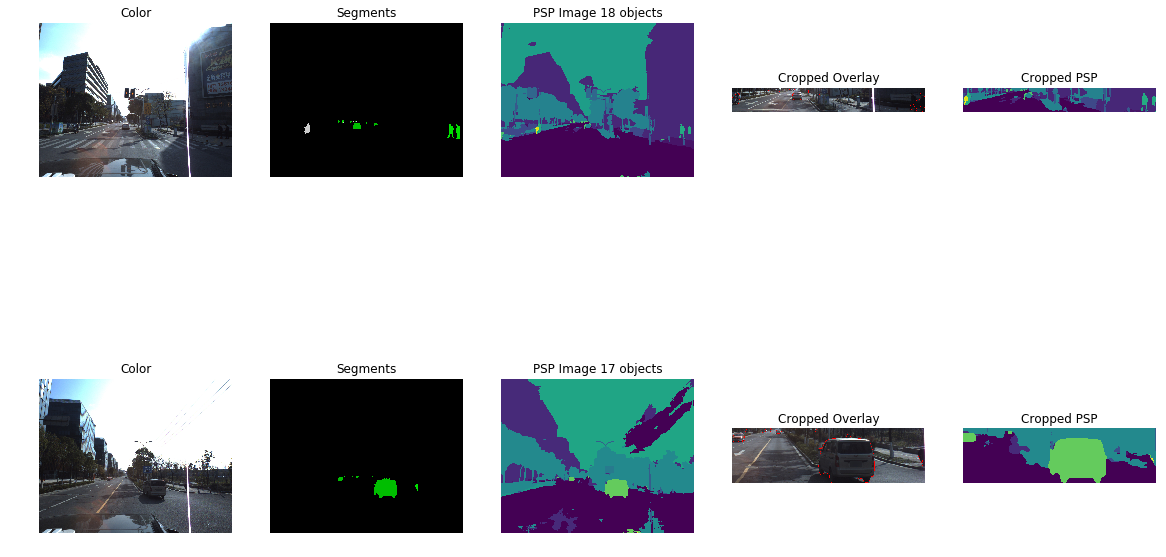

In [43]:
print(train_df.shape[0], 'rows')
sample_rows = 2
fig, m_axs = plt.subplots(sample_rows, 5, figsize = (20, 6*sample_rows))
[c_ax.axis('off') for c_ax in m_axs.flatten()]
out_rows = []
for (ax1, ax2, ax4, ax3, ax_c_crop), (_, c_row) in zip(m_axs, train_df.sample(sample_rows, random_state = 2018).iterrows()):
    c_img = imread(c_row['color'])
    l_img = imread(c_row['labels'])//1000
    seg_img = sess.run(raw_output_up, feed_dict = {pc_img_path: c_row['color']})[0]
    ax1.imshow(c_img)
    ax1.set_title('Color')
    ax2.imshow(l_img, cmap = 'nipy_spectral')
    ax2.set_title('Segments')
    xd, yd = np.where(l_img>0)
    bound_img = mark_boundaries(image = c_img, label_img = l_img, color = (1,0,0), background_label = 255, mode = 'thick')
    ax3.imshow(bound_img[xd.min():xd.max(), yd.min():yd.max(),:])
    ax3.set_title('Cropped Overlay')
    ax4.imshow(seg_img)
    ax4.set_title('PSP Image %d objects' % (np.max(seg_img) % 1000))
    ax_c_crop.imshow(seg_img[xd.min():xd.max(), yd.min():yd.max()])
    ax_c_crop.set_title('Cropped PSP')
fig.savefig('sample_overview.png')

In [78]:
# Decode the Labels from PSP
rev_class_dict = {v: k for k,v in class_dict.items()}
label_names = 'road,siderwalk,building,wall,fence,pole,traffic_light,traffic_sign,vegatation,terrain,sky,person,rider,car,truck,bus,train,motorbicycle,bicycle'.split(',')

In [79]:
idx_to_class = {}
for c_color_idx, c_label in enumerate(label_names):
    if c_label in ['vegatation', 'building', 'sky']:
        print('\t Skipping', c_label)
    if c_label in class_dict:
        print(c_label, class_dict[c_label])
        idx_to_class[c_color_idx] = class_dict[c_label]
    else:
        print('\t', c_label, 'missing')

road 49
siderwalk 50
	 Skipping building
building 97
wall 84
fence 67
pole 82
traffic_light 81
traffic_sign 83
	 Skipping vegatation
vegatation 113
	 terrain missing
	 Skipping sky
sky 17
person 36
rider 37
car 33
truck 38
bus 39
	 train missing
motorbicycle 34
bicycle 35


In [80]:
class_to_idx = {v:k for k,v in idx_to_class.items()}

In [81]:
(np.unique(l_img[l_img>0]), m_axs.flatten())
np.unique(seg_img[l_img==i].ravel())

array([8])

In [82]:
x_bins

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17])

In [83]:
(np.unique(l_img[l_img>0]), m_axs.flatten())

(array([33, 36, 65], dtype=uint16),
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f589c9487b8>,
       dtype=object))

{49: 0, 50: 1, 97: 2, 84: 3, 67: 4, 82: 5, 81: 6, 83: 7, 113: 8, 17: 10, 36: 11, 37: 12, 33: 13, 38: 14, 39: 15, 34: 17, 35: 18}
[8 8 8 ... 0 0 0]
[8 8 8 ... 8 8 0]
[8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8

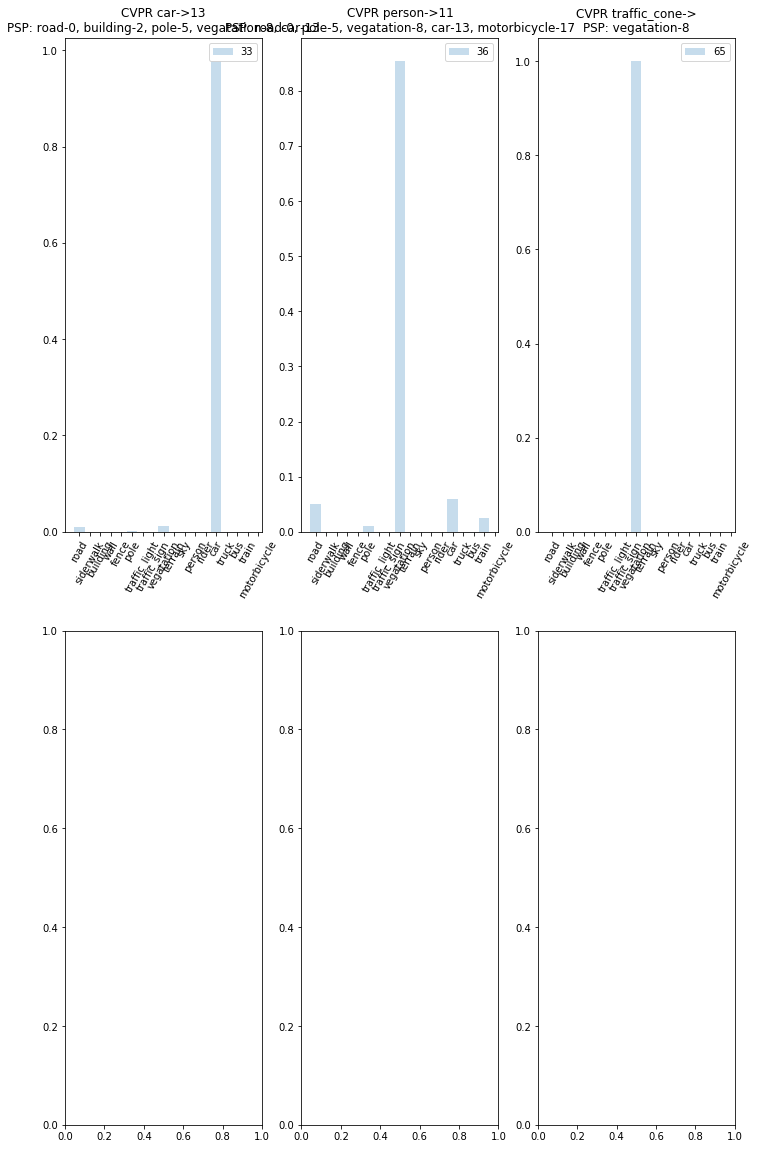

In [86]:
print (class_to_idx)
fig, m_axs = plt.subplots(2,3, figsize = (12,20))
x_bins = np.arange(seg_img.max()+1)
for i, ax1 in zip(np.unique(l_img[l_img>0]), m_axs.flatten()):
    #print (seg_img[l_img==i].ravel())
    un_ids = np.unique(seg_img[l_img==i].ravel())
    
    ax1.hist(seg_img[l_img==i].ravel(), 
             x_bins, label = '{}'.format(i), normed = True, alpha = 0.25)
    ax1.legend()
    
    ax1.set_title('CVPR {}->{}\nPSP: {}'.format(rev_class_dict.get(i, ''), class_to_idx.get(i, ''), ', '.join(
        ['{}-{}'.format(label_names[int(k)], int(k)) for k in un_ids])))
    ax1.set_xticks(x_bins+0.5)
    ax1.set_xticklabels(label_names, rotation = 60)

In [89]:
from skimage.measure import label
def rgb_seg_to_instimg(in_img):
    out_img = np.zeros(in_img.shape, dtype = np.int64)
    for i in np.unique(in_img[in_img>0]):
        if i in idx_to_class:
            j = idx_to_class[i]
            inst_ids = label(in_img==i)[in_img==i]
            out_img[in_img==i] = inst_ids+j*1000
    return out_img

CPU times: user 1h 44min 36s, sys: 4min 37s, total: 1h 49min 13s
Wall time: 14min 48s


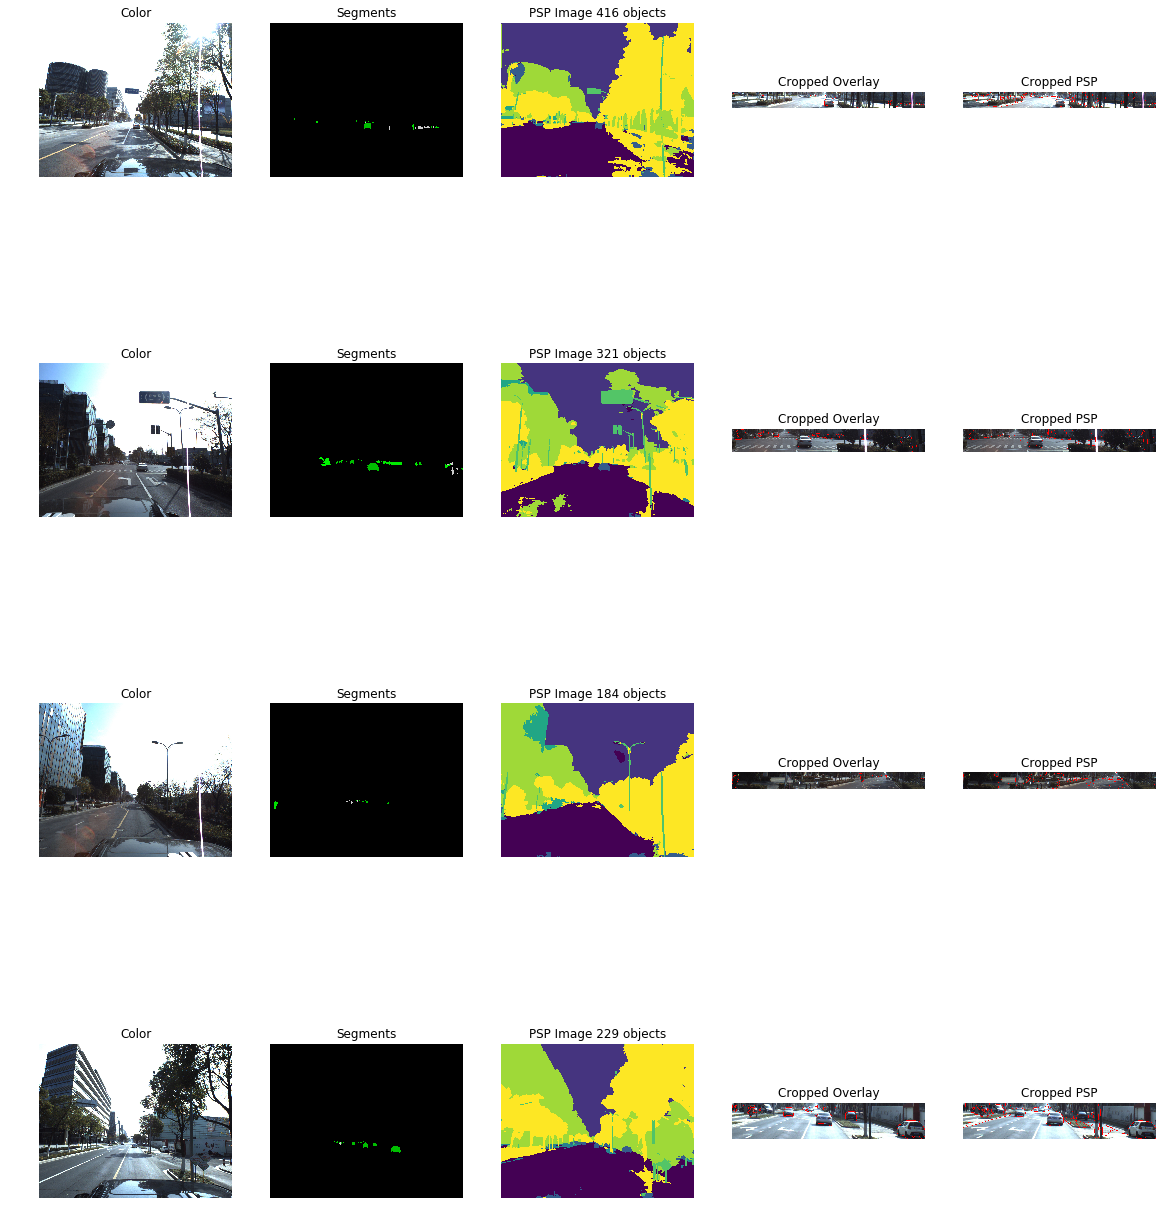

In [91]:
%%time
sample_rows = 4
fig, m_axs = plt.subplots(sample_rows, 5, figsize = (20, 6*sample_rows))
[c_ax.axis('off') for c_ax in m_axs.flatten()]
out_rows = []
for (ax1, ax2, ax4, ax3, ax_c_crop), (_, c_row) in zip(m_axs, train_df.sample(sample_rows, random_state = 2012).iterrows()):
    c_img = imread(c_row['color'])
    l_img = imread(c_row['labels'])//1000
    seg_img = sess.run(raw_output_up, feed_dict = {pc_img_path: c_row['color']})[0]
    c_lab_img = rgb_seg_to_instimg(seg_img)
    ax1.imshow(c_img)
    ax1.set_title('Color')
    ax2.imshow(l_img, cmap = 'nipy_spectral')
    ax2.set_title('Segments')
    xd, yd = np.where(l_img>0)
    bound_img = mark_boundaries(image = c_img, label_img = l_img, color = (1,0,0), background_label = 255, mode = 'thick')
    ax3.imshow(bound_img[xd.min():xd.max(), yd.min():yd.max(),:])
    ax3.set_title('Cropped Overlay')
    ax4.imshow(c_lab_img)
    ax4.set_title('PSP Image %d objects' % (len(np.unique(c_lab_img))))
    psp_bound_img = mark_boundaries(image = c_img, label_img = c_lab_img, color = (1,0,0), background_label = 255, mode = 'thick')
    ax_c_crop.imshow(psp_bound_img[xd.min():xd.max(), yd.min():yd.max()])
    ax_c_crop.set_title('Cropped PSP')
fig.savefig('full_overview.png')

In [93]:
test_df = group_df.query('split=="test"').drop(['labels'], axis = 1)
print(test_df.shape[0], 'rows')
test_df.sample(3)

1344 rows


group,id,split,color
1903,6df9a1d1f2dc6183f0a502c02fdabbc5,test,/home/shared/apoorva_reddy_adavalli_self_drivi...
1675,46dc8cf5cfe60d129b8cca38e3518831,test,/home/shared/apoorva_reddy_adavalli_self_drivi...
2608,faac85238ff977ef74cf966bd13e75fe,test,/home/shared/apoorva_reddy_adavalli_self_drivi...


In [94]:
def rle_encoding(x):
    """ Run-length encoding based on
    https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
    Modified by Konstantin, https://www.kaggle.com/lopuhin
    """
    assert x.dtype == np.bool
    dots = np.where(x.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if b > prev + 1:
            run_lengths.append([b, 0])
        run_lengths[-1][1] += 1
        prev = b
    return '|'.join('{} {}'.format(*pair) for pair in run_lengths)

def segs_to_rle_rows(lab_img, **kwargs):
    out_rows = []
    for i in np.unique(lab_img[lab_img>0]):
        c_dict = dict(**kwargs)
        c_dict['LabelId'] = i//1000
        c_dict['PixelCount'] = np.sum(lab_img==i)
        c_dict['Confidence'] = 0.5 # our classifier isnt very good so lets not put the confidence too high
        c_dict['EncodedPixels'] = rle_encoding(lab_img==i)
        out_rows += [c_dict]
    return out_rows

In [95]:
# make sure it works on a simple case
exp_df = pd.DataFrame(segs_to_rle_rows(c_lab_img, ImageId = -1))
exp_df['LabelName'] = exp_df['LabelId'].map(rev_class_dict.get)
print(exp_df.shape[0], 'rows')
exp_df.sample(5)

228 rows


,Confidence,EncodedPixels,ImageId,LabelId,PixelCount,LabelName
130,0.5,60381 2|63761 7|67145 8|70528 9|73912 10|77296...,-1,97,100,building
25,0.5,6588646 2|6592028 4|6595415 1,-1,33,7,car
209,0.5,6489525 1|6492908 3|6496292 5|6499675 8|650305...,-1,113,84,vegatation
185,0.5,7772376 2|7775750 1|7775760 2|7775782 2|777913...,-1,97,4895,building
173,0.5,6719726 2|6723111 5|6726497 5|6729881 5|673326...,-1,97,26,building
